# Tamil-English Sentiment Analysis

In his notebook I create a fine-tuned model for sentiment analysis of text written in mixed a mixture of Tamil and English language.

I use a __weighted__ version of the loss function to account for the great imbalance in the classes of the dataset.
I also tune the tokenizer to recognize __emojis__ as those are generally relevant to express sentiment.
My model is based on a pre-trained multilingual model which includes Tamil and English; 
this should help in the text classification process.

The dataset was firs published in the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/TamilSentiMix)
and later published in the [Hugging Face Data Repository](https://huggingface.co/datasets/tamilmixsentiment)
from where I read it in this notebook.
The original paper explaining the data set can be found at:
<https://aclanthology.org/2020.sltu-1.28.pdf>

The new model __outperforms__ the original one presented in the paper and based on the original BERT language model.
Hence the use of weights, emojis and a multilingual language schema seems to be an appropriated improved methodology.

The notebook was ran using an Amazon SageMaker Notebook `ml.g5.xlarge`


In [1]:
%pip install matplotlib transformers datasets emojis

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
import emojis
import torch
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import datasets

transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# Use GPU if available
device = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# PARAMETERS

# This is the dataset to be downloaded from https://huggingface.co/datasets/tamilmixsentiment
dataset_name = 'tamilmixsentiment'

# This sets the batch size to be used in the fine tuning
# batch_size, language_model_name = 8, 'distilbert-base-uncased'        # good for sagemaker studio lab
# batch_size, language_model_name = 32, 'bert-base-multilingual-cased'  # good for sagemaker notebook ml.p3.2xlarge
batch_size, language_model_name = 64, 'bert-base-multilingual-cased'  # good for sagemaker notebook ml.g5.xlarge

# DATA
dataset = datasets.load_dataset(dataset_name)

# Use a random subset of the data for development
# dataset = datasets.DatasetDict(
#     {k: v.shuffle(2023).select(range(int(v.num_rows * 0.1))) for k, v in dataset.items()}
# )

dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11335
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3149
    })
})

In [4]:
# Show the training split of the data
dataset['train'].to_pandas()

,text,label
0,Trailer late ah parthavanga like podunga,0
1,Move pathutu vanthu trailer pakurvnga yaru,0
2,Puthupetai dhanush ah yarellam pathinga,0
3,"Dhanush oda character ,puthu sa erukay , mass ta",0
4,vera level ippa pesungada mokka nu thalaivaaaaaa,0
...,...,...
11330,Yuvan shankar Raja anna fan's like here...,0
11331,A masterpiece best revenge film I’ve ever scene,0
11332,Enna pa thala ya kamiya than katringa,0
11333,R A A S H I K H A N N A,3


In [5]:
# TOKENIZATION
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# The tokenizer does not handle emojis
tokenizer.tokenize('🤘')

['[UNK]']

In [6]:
# Here I find out and count the emojis in the training set
my_emojis = [list(emojis.get(x)) for x in dataset['train']['text']]
my_emojis = [y for x in my_emojis for y in x]
pd.Series(my_emojis).value_counts()

🤣    108
🤔     98
🤩     91
🤘     70
🤗     41
🥰     39
🤦     16
🤙     15
🤟      9
🦁      5
🧐      5
🤞      5
🥳      4
🤓      4
🤖      4
🧡      4
🤪      4
🥁      4
🤫      3
🤭      3
🤒      3
🤢      3
🤯      3
🤨      3
🤝      3
🤕      3
🤐      3
🤑      2
🦸      2
🥂      2
🤚      2
🤮      2
🤜      2
🤳      1
🤷      1
🥺      1
🤥      1
🦆      1
🤬      1
🤛      1
🤠      1
🤤      1
🧨      1
🦂      1
🥵      1
🤧      1
dtype: int64

In [7]:
# Here I add emojis as new tokens in the language model
tokenizer.add_tokens(list(set(my_emojis)))

tokenizer.tokenize('🤘')

['🤘']

In [8]:
# Now we are ready to generate embeddings for our text
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)


dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
dataset_encoded = dataset_encoded.remove_columns('text')  # this avoids some unnecessary warnings later
dataset_encoded.set_format('torch')
dataset_encoded

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11335
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3149
    })
})

In [9]:
# MODEL
num_labels = len(set(dataset['train']['label']))

model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name, num_labels=num_labels
).to(device)
model.resize_token_embeddings(len(tokenizer))  # this accounts for the new emoji tokens


# METRICS
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels, preds, average='weighted', zero_division=1)
    acc = sklearn.metrics.accuracy_score(labels, preds)
    bal = sklearn.metrics.balanced_accuracy_score(labels, preds)
    res = {
        'accuracy': acc,
        'balanced': bal,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    return res


# TRAINER
training_args = TrainingArguments(
    output_dir='checkpoints',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='no',
    disable_tqdm=False,
    evaluation_strategy='steps',
    logging_steps=batch_size,
    # logging_steps=100,
    report_to='none',
)


my_weights = 1 / dataset['train'].to_pandas()['label'].value_counts(normalize=True).sort_index()
my_weights = np.log(my_weights)
my_weights = my_weights.tolist()

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        # forward computation
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(my_weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


trainer = WeightedTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['validation'],
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [10]:
# Lets double check some of the parameters before the training
print('num_labels:', num_labels)
print('Weights')
print(my_weights)
print('model.device', model.device)
print('trainer.args.device:', trainer.args.device, flush=True)

num_labels: 5
Weights
[0.3962007007773908, 2.0577119899959677, 2.178694198325993, 2.9238322952317324, 3.4275676247726983]
model.device cuda:0
trainer.args.device: cuda:0


In [11]:
# In[13]:
trainer.train()
trainer.save_model('trained_model')

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11335
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 890
  Number of trainable parameters = 177892613
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,Balanced,F1,Precision,Recall
64,1.550700,1.504894,0.360317,0.230871,0.379429,0.612129,0.360317
128,1.510300,1.402652,0.659524,0.323512,0.599063,0.577967,0.659524
192,1.379900,1.310724,0.556349,0.424203,0.556402,0.590588,0.556349
256,1.307900,1.281775,0.536508,0.442709,0.553698,0.597056,0.536508
320,1.331000,1.277939,0.468254,0.496295,0.506336,0.620558,0.468254
384,1.246700,1.262577,0.446825,0.529801,0.477743,0.639276,0.446825
448,1.214300,1.225978,0.534921,0.538773,0.553685,0.629501,0.534921
512,1.219800,1.227291,0.486508,0.521970,0.527019,0.637379,0.486508
576,1.144500,1.217655,0.541270,0.519671,0.575167,0.641196,0.541270
640,1.118300,1.206923,0.515079,0.527492,0.552272,0.638476,0.515079


***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1260
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/mod

In [12]:
# Model EVALUATION
df = dataset['test'].to_pandas()

pipe = pipeline('sentiment-analysis', model='trained_model', device=device)
predictions = pipe(dataset['test']['text'])

df[['pred', 'prob']] = pd.DataFrame(predictions).values
df['pred'] = df['pred'].str.replace('LABEL_', '').astype(int)

df

loading configuration file trained_model/config.json
Model config BertConfig {
  "_name_or_path": "trained_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolut

,text,label,pred,prob
0,Yarayellam FDFS ppga ippove ready agitinga,0,0,0.323445
1,Ennada viswasam mersal sarkar madhri time la l...,0,1,0.321842
2,yuvan vera level ya .... valuable script. SK i...,0,0,0.646676
3,70 vayasulayum thanoda rasigargala sandhosapad...,2,2,0.458448
4,all the best anna...Telugu makkal selvan fans,0,1,0.393481
...,...,...,...,...
3144,Tamil krish ah irukum oh...,0,1,0.489471
3145,Thalaivaaaaaa... trailer ye pattaiya kelapudhe...,0,2,0.386523
3146,Innum neraya neraya neraya neraya neraya,2,0,0.629299
3147,1:05 to 1:30 Vere level masss,0,0,0.599235


pred,0,1,2,3,4
label,,,,,
0,1280,290,222,256,27
1,114,190,59,55,6
2,162,118,50,41,6
3,40,32,16,81,4
4,11,14,0,1,74


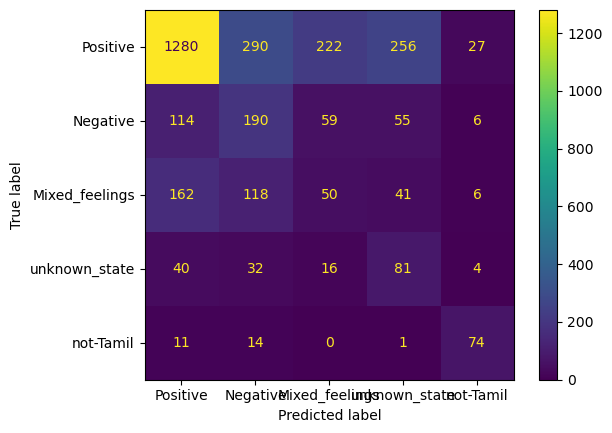

In [13]:
%matplotlib inline

# Lets explore our confusion matrix
cm = sklearn.metrics.confusion_matrix(df['label'], df['pred'])

disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=dataset['test'].features['label'].names)
disp.plot()

pd.crosstab(df['label'], df['pred'])

In [14]:
# And some overall metrics
print(sklearn.metrics.classification_report(df['label'], df['pred'], target_names=dataset['test'].features['label'].names, zero_division=1))

                precision    recall  f1-score   support

      Positive       0.80      0.62      0.70      2075
      Negative       0.30      0.45      0.36       424
Mixed_feelings       0.14      0.13      0.14       377
 unknown_state       0.19      0.47      0.27       173
     not-Tamil       0.63      0.74      0.68       100

      accuracy                           0.53      3149
     macro avg       0.41      0.48      0.43      3149
  weighted avg       0.61      0.53      0.56      3149

